# TODO:

1. pytorch model training
2. data augmentation

In [2]:
import sys
sys.path.append('../../')

import torch
from torch.utils.data import Dataset, DataLoader
import skimage
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [5]:
from model.networks import custom_resnet34

In [16]:
gpu_id = 2
num_cores = 4
torch.cuda.set_device(gpu_id)

In [17]:
bs = 8  # batch size
size = 256  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/hr/')

In [39]:
k = np.sqrt(9).is_integer();k

True

In [100]:
class EMDataSet(Dataset):

    def __init__(self, data_pth, n_pieces):
        self.img_list = list(data_pth.glob('*.tif'))
        if not np.sqrt(n_pieces).is_integer():
            raise ValueError(f'The number of pieces should be a square number, however {n_pieces} gets passed in.')
        self.n_pieces = n_pieces
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.img_list[idx]
        image = torch.FloatTensor(skimage.io.imread(img_name)[:,:,0])
        h, w = image.shape
        n_pieces_1d = int(np.sqrt(self.n_pieces))
        piece_h, piece_w = int(h/n_pieces_1d), int(w/n_pieces_1d)
        pieces = torch.stack([image[i*piece_h:(i+1)*piece_h, j*piece_w:(j+1)*piece_w] 
                          for i in range(n_pieces_1d) for j in range(n_pieces_1d)])
        indices = torch.randperm(self.n_pieces)

        self.x = pieces[indices]
        self.y = indices

        #dev
#         shuffled = torch.zeros([h, w])
#         for piece, coor in zip(self.x, [(0,0), (0,1), (1,0), (1,1)]):
#             shuffled[coor[0]*piece_h:(coor[0]+1)*piece_h, 
#                      coor[1]*piece_w:(coor[1]+1)*piece_w] = piece
#         original = image
#         return (shuffled, original), self.y
        return self.x, self.y

In [101]:
jigsaw_dataset = EMDataSet(data_pth, n_pieces=4)

In [102]:
dataloader = DataLoader(jigsaw_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

In [103]:
db = DataBunch.create(train_ds=jigsaw_dataset, valid_ds=None)

# initiate pytorch model

In [7]:
four_c_resnet = partial(custom_resnet34, c_in=4)

# dev

In [89]:
xb, yb = db.one_batch()

tensor([2, 4, 3, 1])


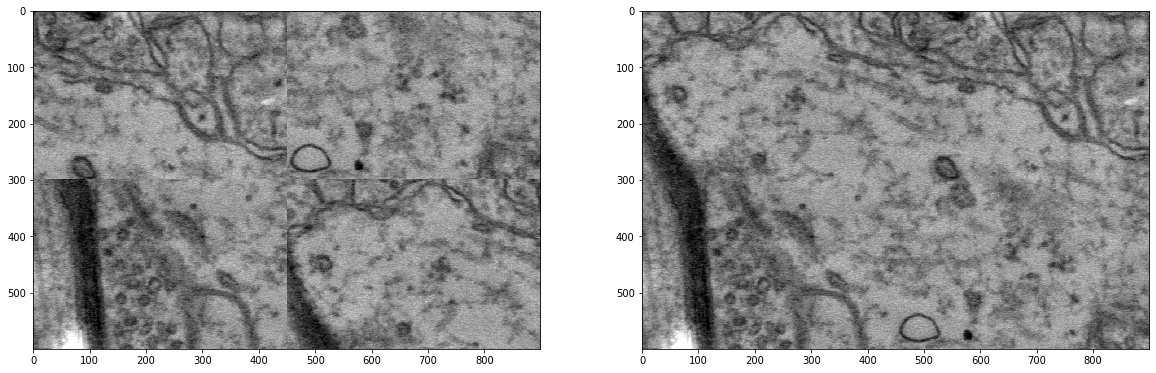

In [99]:
shuffled, original = xb
indices = yb[0]
print(indices+1)
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.subplot(1,2,1)
plt.imshow(shuffled[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(original[0], cmap='gray')
plt.show()

0 torch.Size([4, 600, 900])
1 torch.Size([4, 600, 900])
2 torch.Size([4, 600, 900])
3 torch.Size([4, 600, 900])


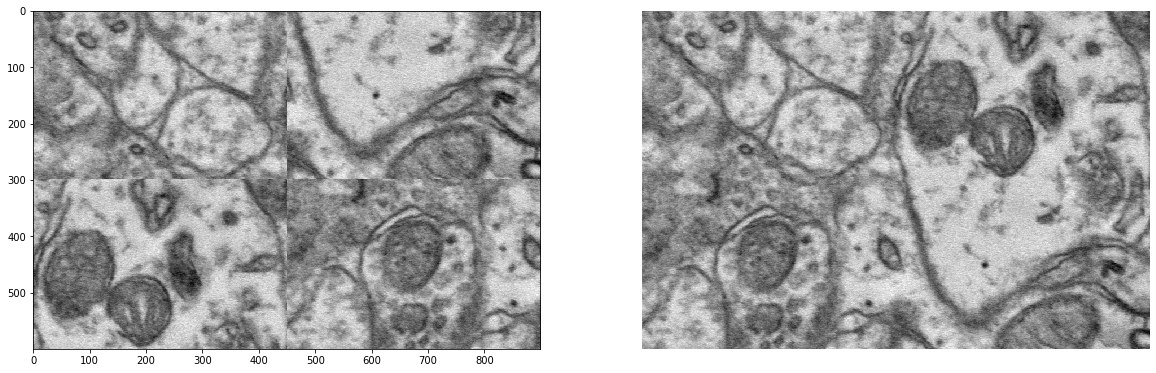

In [64]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['shuffled'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure(figsize=(20,20))
        plt.subplot(1,2,1)
        plt.imshow(sample_batched['shuffled'][3], cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(sample_batched['original'][3], cmap='gray')
        plt.axis('off')
        plt.ioff()
        plt.show()
        break